In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import and mounting the EmoSound and IADSED Dataset

In [3]:
file_path = '/content/drive/MyDrive/NLP Project Team 4/P1-2/EmoSound/EmoSounds-3.csv'
emosound_df = pd.read_csv(file_path, usecols=range(5, len(pd.read_csv(file_path, nrows=1).columns)))

In [4]:
file_path = '/content/drive/MyDrive/NLP Project Team 4/P1-2/IADSED/IADSED.csv'
iadsed_df = pd.read_csv(file_path, usecols=range(5, len(pd.read_csv(file_path, nrows=1).columns)))

### Shuffle the dataset to remove any patterns

In [5]:
def shuffle_dataset(df):
  # 1. Add random column for shuffling
  df['random'] = np.random.rand(len(df))

  # 2. Shuffle dataset based on random column and drop random column
  df_shuffled = df.sort_values('random').drop('random', axis=1)

  return df_shuffled

In [6]:
emosound_df = shuffle_dataset(emosound_df)
iadsed_df = shuffle_dataset(iadsed_df)

### Print DataFrame and drop missing columns

In [7]:
emosound_df.head()

,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,rhythm_attacktime_mean,rhythm_eventdensity_mean,rhythm_fluctuationmax_peakposmean,rhythm_pulseclarity_mean,rhythm_tempo_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
215,0.907667,-0.757626,0.045860,0.019061,452.096973,0.023592,2.782324,3.223202,0.136554,123.377036,...,5.478298,2.170691,40.420832,17.369645,0.255304,0.282400,0.411958,0.142529,-0.061117,0.076404
149,-0.475680,-0.101401,0.014208,0.007459,157.814966,0.014379,2.618658,2.439290,0.329532,154.724713,...,4.723501,0.761932,5.301423,1.844115,0.163445,0.088778,0.690370,0.088318,0.085264,0.099729
59,0.731245,-0.685078,0.042078,0.042853,596.086119,0.046241,0.818331,2.855468,0.175892,107.870364,...,5.974513,1.560172,40.742204,45.842377,0.278217,0.399941,0.463191,0.205138,-0.049519,0.064066
188,0.050289,-0.188788,0.042719,0.022888,156.918197,0.017830,0.818331,2.272265,0.170156,100.138722,...,5.381378,2.236977,7.670286,5.697607,0.077151,0.075230,0.495683,0.081046,-0.037473,0.046653
99,-0.891179,0.886232,0.001538,0.000718,799.593549,0.031250,0.818331,2.380159,0.152751,122.544122,...,5.261850,1.160511,1.190746,0.977613,0.342450,0.190904,0.383523,0.132899,-0.032176,0.093209


In [8]:
print("emosound Dataset Shape:", emosound_df.shape)
print("\n emosound Missing Values:\n", emosound_df.isnull().sum())

emosound Dataset Shape: (600, 70)

 emosound Missing Values:
 arousal                  0
valence                  0
dynamics_rms_mean        0
dynamics_rms_std         0
pitch_pitch_mean         0
                        ..
tonal_hcdf_std           0
tonal_keyclarity_mean    0
tonal_keyclarity_std     0
tonal_mode_mean          0
tonal_mode_std           0
Length: 70, dtype: int64


In [9]:
iadsed_df.head()

,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
831,6.136364,3.227273,4.55,0.085427,0.073318,0.047434,129.618422,12.984889,0.139187,1.666667,...,2.833336,87.863199,77.156128,619.821583,0.447728,0.172425,-0.027887,0.067540,0.318489,0.363490
448,4.727273,4.318182,4.91,0.032474,0.023490,0.019835,156.355967,24.378333,0.140026,2.666667,...,2.584791,26.642731,19.106480,502.870814,0.364457,0.255671,-0.032494,0.067109,0.278894,0.395617
789,4.120000,4.760000,5.44,0.098279,0.019838,0.053673,121.364414,40.626607,0.134068,5.993658,...,0.527963,41.344120,8.707508,1400.381048,0.231148,0.048137,0.001329,0.053653,0.093903,0.041374
105,5.136364,4.136364,4.41,0.070132,0.065443,0.025363,146.504056,1.617436,0.459238,2.166667,...,3.100222,55.810952,51.972605,805.670326,0.542217,0.134115,0.003048,0.069109,0.229892,0.182095
446,6.080000,3.640000,3.80,0.097509,0.076612,0.034136,142.341765,35.302765,0.089129,2.000000,...,2.927236,79.043965,64.485914,423.629648,0.419750,0.210455,-0.026895,0.081627,0.272154,0.334356


In [10]:
print("iadsed Dataset Shape:", iadsed_df.shape)
print("\n iadsed Missing Values:\n", iadsed_df.isnull().sum())

iadsed Dataset Shape: (935, 71)

 iadsed Missing Values:
 arousal                 0
valence                 0
dominance               0
dynamics_rms_mean       0
dynamics_rms_std        0
                       ..
tonal_keyclarity_std    6
tonal_mode_mean         0
tonal_mode_std          6
tonal_hcdf_mean         0
tonal_hcdf_std          6
Length: 71, dtype: int64


In [11]:
iadsed_df_cleaned = iadsed_df.dropna().copy()

In [12]:
print("\n iadsed Missing Values:\n", iadsed_df_cleaned.isnull().sum())


 iadsed Missing Values:
 arousal                 0
valence                 0
dominance               0
dynamics_rms_mean       0
dynamics_rms_std        0
                       ..
tonal_keyclarity_std    0
tonal_mode_mean         0
tonal_mode_std          0
tonal_hcdf_mean         0
tonal_hcdf_std          0
Length: 71, dtype: int64


### Classification Function

In [13]:
def create_class_labels(row):
    if row['arousal'] >= 0 and row['valence'] >= 0:
        return 0  # Positive Arousal, Positive Valence
    elif row['arousal'] >= 0 and row['valence'] < 0:
        return 1  # Positive Arousal, Negative Valence
    elif row['arousal'] < 0 and row['valence'] < 0:
        return 2  # Negative Arousal, Negative Valence
    else:
        return 3  # Negative Arousal, Positive Valence

In [14]:
emosound_df

,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,rhythm_attacktime_mean,rhythm_eventdensity_mean,rhythm_fluctuationmax_peakposmean,rhythm_pulseclarity_mean,rhythm_tempo_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
215,0.907667,-0.757626,0.045860,0.019061,452.096973,0.023592,2.782324,3.223202,0.136554,123.377036,...,5.478298,2.170691,40.420832,17.369645,0.255304,0.282400,0.411958,0.142529,-0.061117,0.076404
149,-0.475680,-0.101401,0.014208,0.007459,157.814966,0.014379,2.618658,2.439290,0.329532,154.724713,...,4.723501,0.761932,5.301423,1.844115,0.163445,0.088778,0.690370,0.088318,0.085264,0.099729
59,0.731245,-0.685078,0.042078,0.042853,596.086119,0.046241,0.818331,2.855468,0.175892,107.870364,...,5.974513,1.560172,40.742204,45.842377,0.278217,0.399941,0.463191,0.205138,-0.049519,0.064066
188,0.050289,-0.188788,0.042719,0.022888,156.918197,0.017830,0.818331,2.272265,0.170156,100.138722,...,5.381378,2.236977,7.670286,5.697607,0.077151,0.075230,0.495683,0.081046,-0.037473,0.046653
99,-0.891179,0.886232,0.001538,0.000718,799.593549,0.031250,0.818331,2.380159,0.152751,122.544122,...,5.261850,1.160511,1.190746,0.977613,0.342450,0.190904,0.383523,0.132899,-0.032176,0.093209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,-0.675185,0.713108,0.006701,0.002169,869.149928,0.012332,3.273322,2.559199,0.142818,100.805126,...,4.673339,0.484470,4.267751,1.273880,0.338743,0.162383,0.451281,0.132102,-0.031682,0.098327
31,-0.998351,0.225062,0.000504,0.001021,574.404807,0.127413,0.818331,2.398601,0.119705,113.570454,...,5.882708,1.083246,0.621124,1.449162,0.424042,0.420066,0.404697,0.183361,-0.031606,0.075943
400,-0.244847,0.187139,0.022625,0.005800,819.219856,0.015273,7.364975,3.080122,0.106344,104.798335,...,5.371065,1.242320,19.581586,6.927357,0.341929,0.157486,0.421339,0.113590,-0.019436,0.094179
561,-0.711459,0.797197,0.004080,0.000705,746.803888,0.040195,6.546645,2.952011,0.125908,145.581317,...,4.825890,0.466025,3.577622,0.767728,0.293492,0.117571,0.465874,0.122817,-0.018773,0.101286


In [15]:
iadsed_df_cleaned

,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
831,6.136364,3.227273,4.55,0.085427,0.073318,0.047434,129.618422,12.984889,0.139187,1.666667,...,2.833336,87.863199,77.156128,619.821583,0.447728,0.172425,-0.027887,0.067540,0.318489,0.363490
448,4.727273,4.318182,4.91,0.032474,0.023490,0.019835,156.355967,24.378333,0.140026,2.666667,...,2.584791,26.642731,19.106480,502.870814,0.364457,0.255671,-0.032494,0.067109,0.278894,0.395617
789,4.120000,4.760000,5.44,0.098279,0.019838,0.053673,121.364414,40.626607,0.134068,5.993658,...,0.527963,41.344120,8.707508,1400.381048,0.231148,0.048137,0.001329,0.053653,0.093903,0.041374
105,5.136364,4.136364,4.41,0.070132,0.065443,0.025363,146.504056,1.617436,0.459238,2.166667,...,3.100222,55.810952,51.972605,805.670326,0.542217,0.134115,0.003048,0.069109,0.229892,0.182095
446,6.080000,3.640000,3.80,0.097509,0.076612,0.034136,142.341765,35.302765,0.089129,2.000000,...,2.927236,79.043965,64.485914,423.629648,0.419750,0.210455,-0.026895,0.081627,0.272154,0.334356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,4.636364,4.090909,4.77,0.097457,0.084331,0.017217,132.192821,13.707610,0.610715,5.500000,...,3.032345,95.918475,91.753122,333.699030,0.263908,0.203087,-0.009743,0.067692,0.209342,0.206251
127,5.560000,3.600000,3.68,0.064850,0.054668,0.062371,101.807513,0.830413,0.606447,2.166667,...,2.405375,43.733454,34.974763,287.424553,0.457056,0.159881,-0.033725,0.079055,0.202569,0.250314
607,6.772727,7.954545,6.27,0.192050,0.063888,0.019587,141.530633,3.127317,0.225259,2.833333,...,1.901355,93.694498,66.805184,325.172338,0.538585,0.147382,-0.022251,0.089469,0.187191,0.202153
68,4.000000,6.875000,5.04,0.130586,0.038875,0.029817,131.344285,18.931505,0.228012,3.166667,...,1.175432,67.108875,27.704993,424.012151,0.566700,0.106719,0.041998,0.076927,0.145790,0.091318


In [16]:
emosound_df['class'] = emosound_df.apply(create_class_labels, axis=1)
iadsed_df_cleaned['class'] = iadsed_df_cleaned.apply(create_class_labels, axis=1)

In [17]:
emosound_df.head()

,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,rhythm_attacktime_mean,rhythm_eventdensity_mean,rhythm_fluctuationmax_peakposmean,rhythm_pulseclarity_mean,rhythm_tempo_mean,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,class
215,0.907667,-0.757626,0.045860,0.019061,452.096973,0.023592,2.782324,3.223202,0.136554,123.377036,...,2.170691,40.420832,17.369645,0.255304,0.282400,0.411958,0.142529,-0.061117,0.076404,1
149,-0.475680,-0.101401,0.014208,0.007459,157.814966,0.014379,2.618658,2.439290,0.329532,154.724713,...,0.761932,5.301423,1.844115,0.163445,0.088778,0.690370,0.088318,0.085264,0.099729,2
59,0.731245,-0.685078,0.042078,0.042853,596.086119,0.046241,0.818331,2.855468,0.175892,107.870364,...,1.560172,40.742204,45.842377,0.278217,0.399941,0.463191,0.205138,-0.049519,0.064066,1
188,0.050289,-0.188788,0.042719,0.022888,156.918197,0.017830,0.818331,2.272265,0.170156,100.138722,...,2.236977,7.670286,5.697607,0.077151,0.075230,0.495683,0.081046,-0.037473,0.046653,1
99,-0.891179,0.886232,0.001538,0.000718,799.593549,0.031250,0.818331,2.380159,0.152751,122.544122,...,1.160511,1.190746,0.977613,0.342450,0.190904,0.383523,0.132899,-0.032176,0.093209,3


In [18]:
iadsed_df_cleaned.head()

,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,...,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std,class
831,6.136364,3.227273,4.55,0.085427,0.073318,0.047434,129.618422,12.984889,0.139187,1.666667,...,87.863199,77.156128,619.821583,0.447728,0.172425,-0.027887,0.067540,0.318489,0.363490,0
448,4.727273,4.318182,4.91,0.032474,0.023490,0.019835,156.355967,24.378333,0.140026,2.666667,...,26.642731,19.106480,502.870814,0.364457,0.255671,-0.032494,0.067109,0.278894,0.395617,0
789,4.120000,4.760000,5.44,0.098279,0.019838,0.053673,121.364414,40.626607,0.134068,5.993658,...,41.344120,8.707508,1400.381048,0.231148,0.048137,0.001329,0.053653,0.093903,0.041374,0
105,5.136364,4.136364,4.41,0.070132,0.065443,0.025363,146.504056,1.617436,0.459238,2.166667,...,55.810952,51.972605,805.670326,0.542217,0.134115,0.003048,0.069109,0.229892,0.182095,0
446,6.080000,3.640000,3.80,0.097509,0.076612,0.034136,142.341765,35.302765,0.089129,2.000000,...,79.043965,64.485914,423.629648,0.419750,0.210455,-0.026895,0.081627,0.272154,0.334356,0


### Save the dataset

In [19]:
emosound_df.to_csv('final_emosounds.csv', index=False)
iadsed_df_cleaned.to_csv('final_emosounds.csv', index=False)

### Vizualization of classes

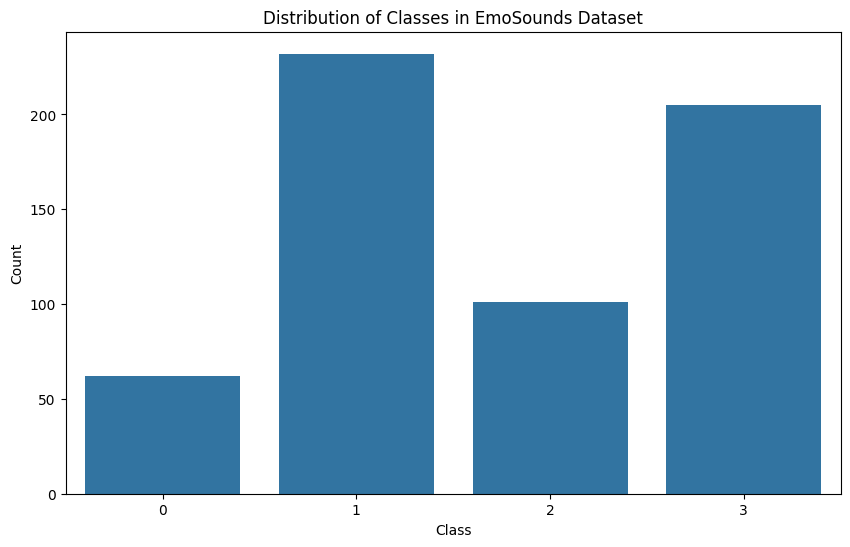

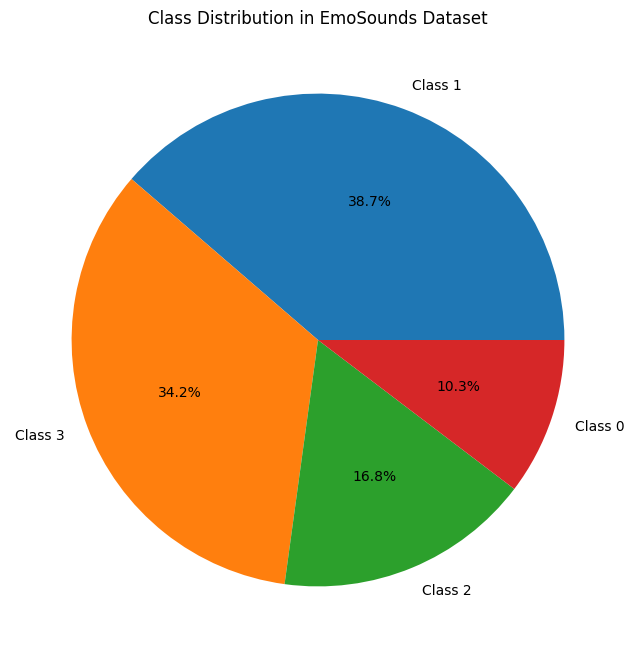


Class Distribution:
Class 0: 62 samples (10.3%)
Class 1: 232 samples (38.7%)
Class 2: 101 samples (16.8%)
Class 3: 205 samples (34.2%)


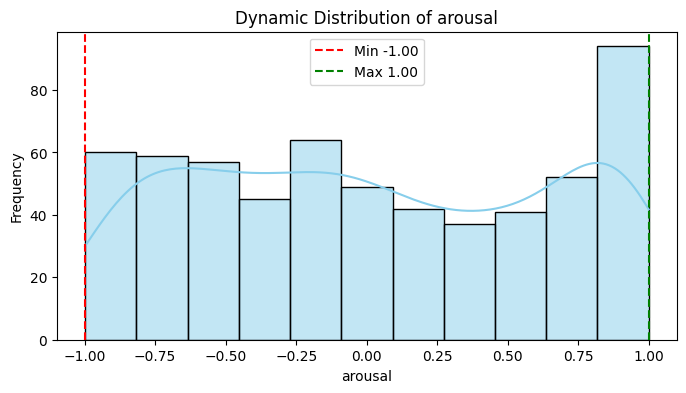

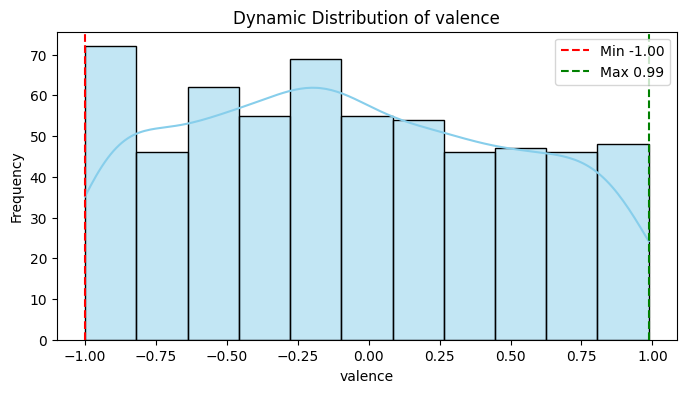

In [20]:
# Create count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=emosound_df, x='class')
plt.title('Distribution of Classes in EmoSounds Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Create pie chart
class_counts = emosound_df['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index], autopct='%1.1f%%')
plt.title('Class Distribution in EmoSounds Dataset')
plt.show()

# Print class distribution
print("\nClass Distribution:")
for class_num in sorted(class_counts.index):
    print(f"Class {class_num}: {class_counts[class_num]} samples ({(class_counts[class_num]/len(emosound_df)*100):.1f}%)")

# Check  Distribution of values
columns_to_check = ['arousal', 'valence']

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.histplot(emosound_df[col], kde=True, color='skyblue')
    plt.axvline(emosound_df[col].min(), color='red', linestyle='--', label=f'Min {emosound_df[col].min():.2f}')
    plt.axvline(emosound_df[col].max(), color='green', linestyle='--', label=f'Max {emosound_df[col].max():.2f}')
    plt.title(f"Dynamic Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

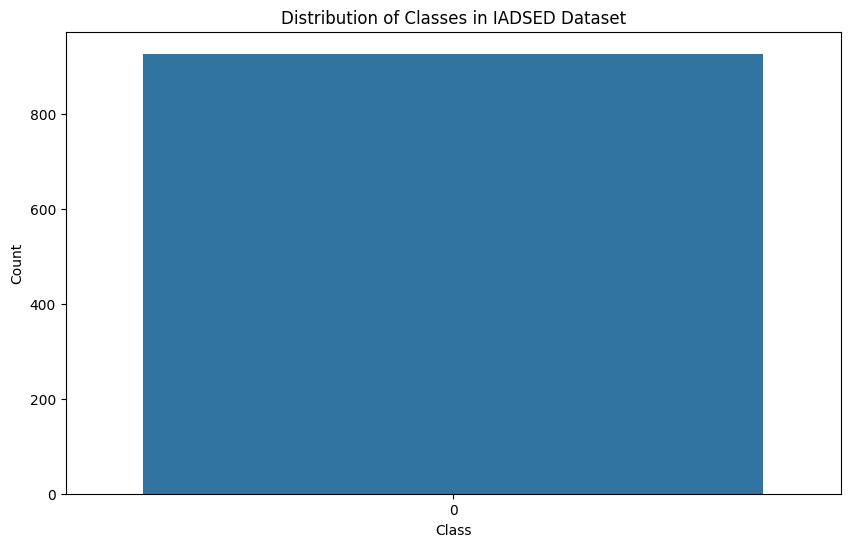

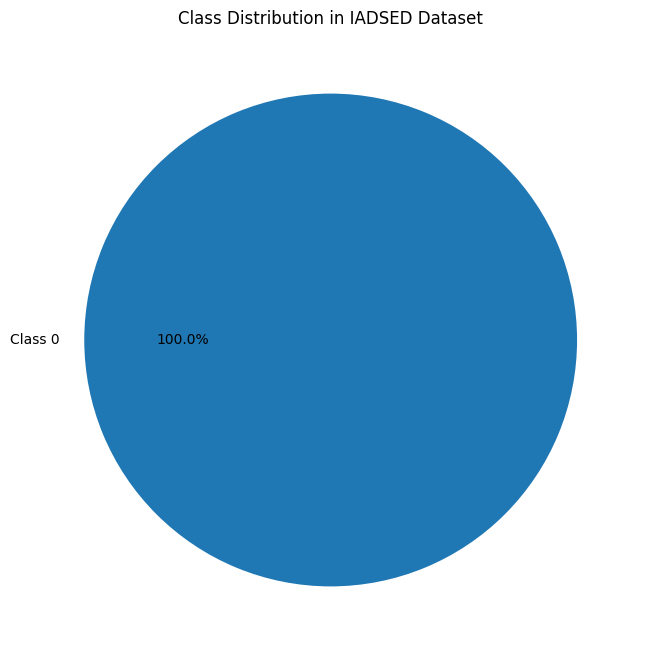


Class Distribution:
Class 0: 927 samples (100.0%)


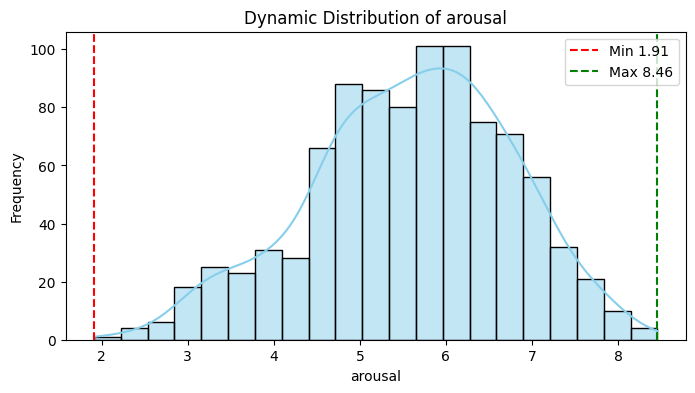

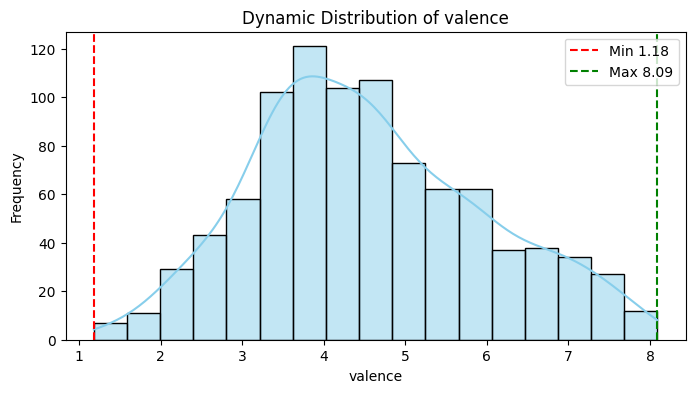

In [21]:
# Create count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=iadsed_df_cleaned, x='class')
plt.title('Distribution of Classes in IADSED Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Create pie chart
class_counts = iadsed_df_cleaned['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index], autopct='%1.1f%%')
plt.title('Class Distribution in IADSED Dataset')
plt.show()

# Print class distribution
print("\nClass Distribution:")
for class_num in sorted(class_counts.index):
    print(f"Class {class_num}: {class_counts[class_num]} samples ({(class_counts[class_num]/len(iadsed_df_cleaned)*100):.1f}%)")

# Check  Distribution of values
columns_to_check = ['arousal', 'valence']

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.histplot(iadsed_df_cleaned[col], kde=True, color='skyblue')
    plt.axvline(iadsed_df_cleaned[col].min(), color='red', linestyle='--', label=f'Min {iadsed_df_cleaned[col].min():.2f}')
    plt.axvline(iadsed_df_cleaned[col].max(), color='green', linestyle='--', label=f'Max {iadsed_df_cleaned[col].max():.2f}')
    plt.title(f"Dynamic Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

### Scaling the IADSED Dataset

In [22]:
def standardize_dataset(df):
    feature_scaler = MinMaxScaler(feature_range=(-1, 1))

    # Separate columns
    metadata_cols = ['dataset', 'fnames', 'genre', 'splits', 'vocals']
    target_cols = ['arousal', 'valence']
    feature_cols = [col for col in df.columns if col not in metadata_cols + target_cols]

    X = df[feature_cols]
    X_scaled = feature_scaler.fit_transform(X)

    # Scale arousal and valence separately to [-1, 1]
    target_scaler = MinMaxScaler(feature_range=(-1, 1))
    targets = df[target_cols]
    targets_scaled = target_scaler.fit_transform(targets)

    # Create new dataframe with scaled values
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
    df_scaled['arousal'] = targets_scaled[:, 0]
    df_scaled['valence'] = targets_scaled[:, 1]

    # Add back metadata columns
    for col in metadata_cols:
        if col in df.columns:
            df_scaled[col] = df[col]

    return df_scaled

iadsed_df_cleaned = iadsed_df_cleaned.drop('class', axis=1)
iadsed_scaled = standardize_dataset(iadsed_df_cleaned)
iadsed_scaled['class'] = iadsed_scaled.apply(create_class_labels, axis=1)

In [23]:
# Scatter Plot of Arousal vs. Valence
def scatter_plot(df):
    plt.figure(figsize=(8, 8))
    plt.scatter(df['valence'], df['arousal'], alpha=0.6, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.title("Scatter Plot of Arousal vs. Valence", fontsize=14)
    plt.xlabel("Valence", fontsize=12)
    plt.ylabel("Arousal", fontsize=12)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid(alpha=0.3)
    plt.show()

# Circular Emotion Model Visualization
def circular_emotion_model(df):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot of data points
    ax.scatter(df['valence'], df['arousal'], alpha=0.6, color='gray')

    # Add quadrant labels
    ax.text(1.5, 1.5, "I\nHigh-Arousal\nPositive-Valence", color='red', fontsize=10, ha='center')
    ax.text(-1.5, 1.5, "II\nHigh-Arousal\nNegative-Valence", color='red', fontsize=10, ha='center')
    ax.text(-1.5, -1.5, "III\nLow-Arousal\nNegative-Valence", color='red', fontsize=10, ha='center')
    ax.text(1.5, -1.5, "IV\nLow-Arousal\nPositive-Valence", color='red', fontsize=10, ha='center')

    # Add axis labels
    ax.set_xlabel("VALENCE", fontsize=12)
    ax.set_ylabel("AROUSAL", fontsize=12)

    # Add quadrant lines
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)

    # Add circular boundary
    circle = plt.Circle((0, 0), 2, color='black', fill=False, linestyle='--')
    ax.add_artist(circle)

    # Set limits and aspect ratio
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal', 'box')

    # Add grid and title
    ax.grid(alpha=0.3)
    ax.set_title("Circular Emotion Model", fontsize=14)

    plt.show()

### Emosound Vizualization

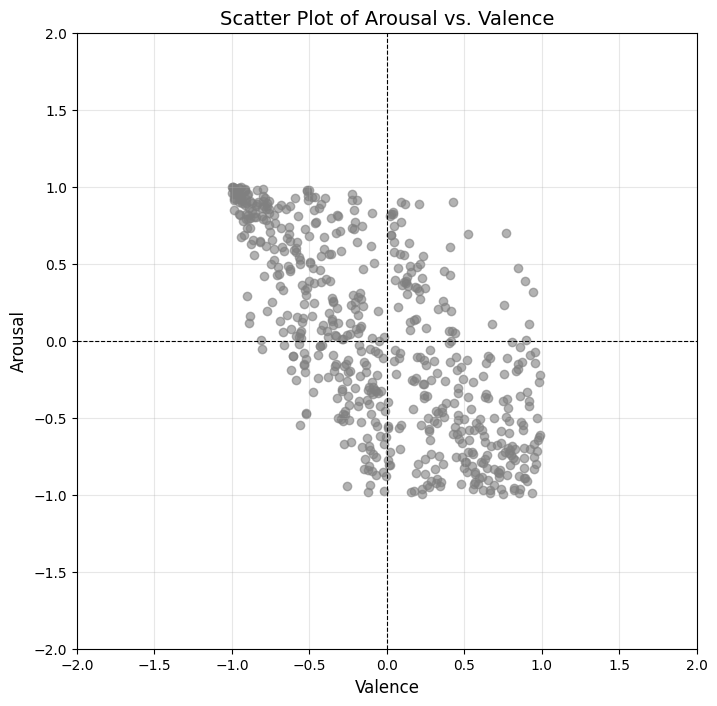

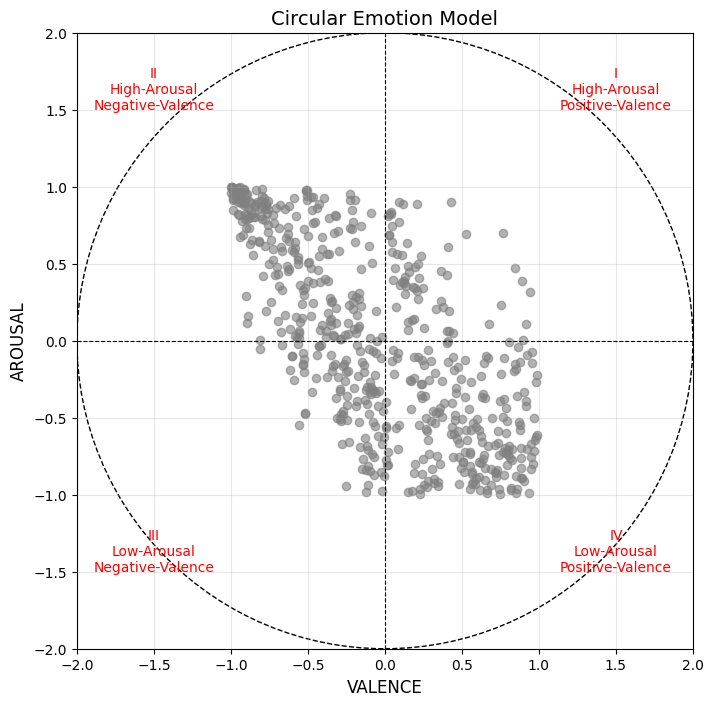

In [24]:
scatter_plot(emosound_df)
circular_emotion_model(emosound_df)

### IADSED Vizualization

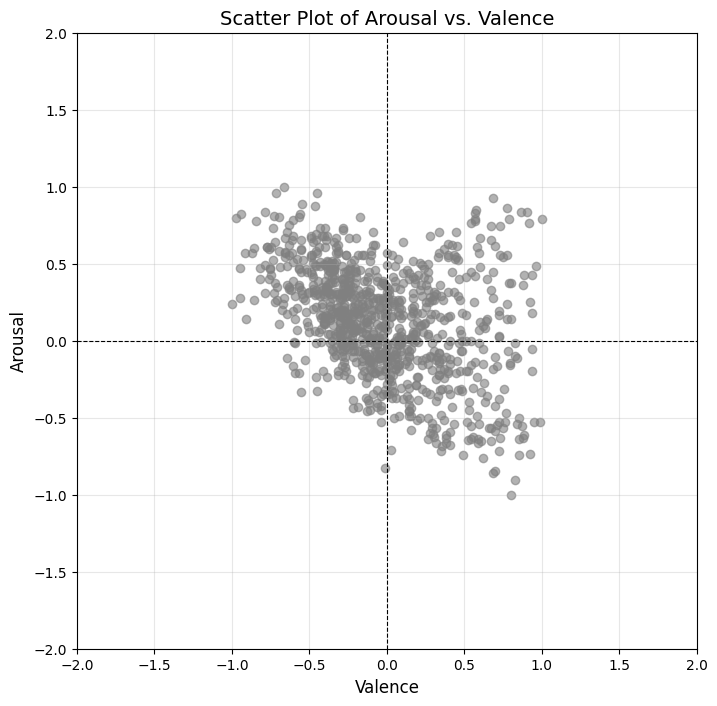

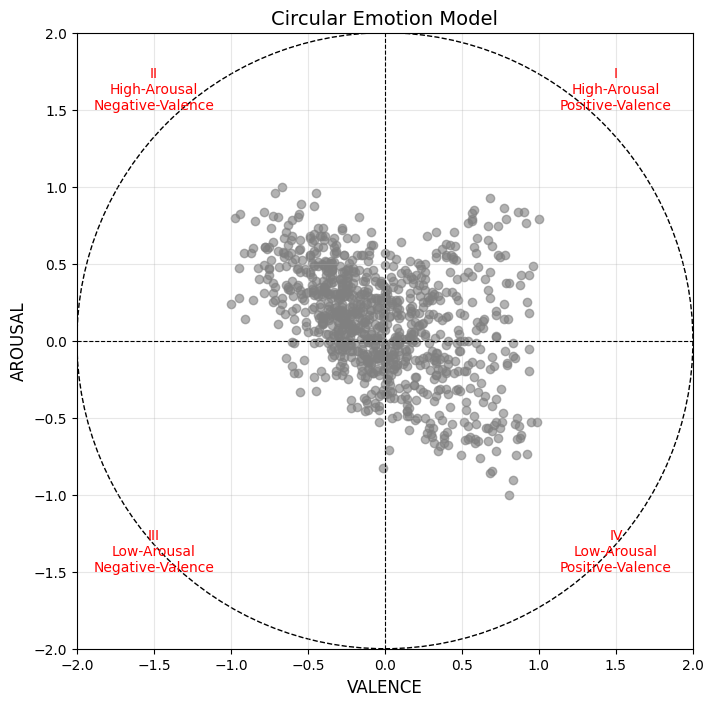

In [25]:
scatter_plot(iadsed_scaled)
circular_emotion_model(iadsed_scaled)

### Train Test Split

In [26]:
iadsed_scaled.head()

,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,rhythm_fluctuationmax_peakposmean,spectral_centroid_mean,...,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std,arousal,valence,class
0,-0.026718,-0.780489,-0.582280,-0.823517,0.155844,-0.628871,-0.671345,-0.735294,-0.365407,-0.718949,...,-0.501075,0.071801,-0.085534,0.118754,-0.154101,-0.291351,0.223134,0.290920,-0.407895,1
1,0.110687,-0.925753,-0.879978,-0.942102,0.533576,-0.303138,-0.669473,-0.558824,-0.545887,-0.543048,...,-0.611781,-0.131206,0.365752,0.086589,-0.159589,-0.379616,0.331758,-0.139387,-0.092105,2
2,0.312977,-0.745232,-0.901797,-0.796710,0.039236,0.161393,-0.682767,0.028293,-0.582640,-0.056649,...,0.237805,-0.456201,-0.759313,0.322735,-0.330910,-0.791998,-0.865964,-0.324835,0.035789,3
3,-0.080153,-0.822447,-0.629329,-0.918350,0.394394,-0.953861,0.042745,-0.647059,-0.628187,-0.602827,...,-0.325150,0.302157,-0.293217,0.334737,-0.134125,-0.488851,-0.390176,-0.014459,-0.144737,2
4,-0.312977,-0.747345,-0.562600,-0.880654,0.335592,0.009187,-0.783034,-0.676471,-0.538258,-0.651062,...,-0.686791,0.003593,0.120631,0.125680,0.025254,-0.394641,0.124630,0.273707,-0.288421,1


In [27]:
emosound_df.head()

,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,rhythm_attacktime_mean,rhythm_eventdensity_mean,rhythm_fluctuationmax_peakposmean,rhythm_pulseclarity_mean,rhythm_tempo_mean,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,class
215,0.907667,-0.757626,0.045860,0.019061,452.096973,0.023592,2.782324,3.223202,0.136554,123.377036,...,2.170691,40.420832,17.369645,0.255304,0.282400,0.411958,0.142529,-0.061117,0.076404,1
149,-0.475680,-0.101401,0.014208,0.007459,157.814966,0.014379,2.618658,2.439290,0.329532,154.724713,...,0.761932,5.301423,1.844115,0.163445,0.088778,0.690370,0.088318,0.085264,0.099729,2
59,0.731245,-0.685078,0.042078,0.042853,596.086119,0.046241,0.818331,2.855468,0.175892,107.870364,...,1.560172,40.742204,45.842377,0.278217,0.399941,0.463191,0.205138,-0.049519,0.064066,1
188,0.050289,-0.188788,0.042719,0.022888,156.918197,0.017830,0.818331,2.272265,0.170156,100.138722,...,2.236977,7.670286,5.697607,0.077151,0.075230,0.495683,0.081046,-0.037473,0.046653,1
99,-0.891179,0.886232,0.001538,0.000718,799.593549,0.031250,0.818331,2.380159,0.152751,122.544122,...,1.160511,1.190746,0.977613,0.342450,0.190904,0.383523,0.132899,-0.032176,0.093209,3


In [28]:
X_emosound = emosound_df.drop(['arousal', 'valence', 'class'], axis=1)
y_emosound = emosound_df['class']
X_iadsed = iadsed_scaled.drop(['arousal', 'valence', 'class'], axis=1)
y_iadsed = iadsed_scaled['class']

In [29]:
X_emosound_temp, X_emosound_test, y_emosound_temp, y_emosound_test = train_test_split(X_emosound, y_emosound, test_size=0.2, random_state=42)
X_emosound_train, X_emosound_val, y_emosound_train, y_emosound_val = train_test_split(X_emosound_temp, y_emosound_temp, test_size=0.25, random_state=42)

In [30]:
X_iadsed_temp, X_iadsed_test, y_iadsed_temp, y_iadsed_test = train_test_split(X_iadsed, y_iadsed, test_size=0.2, random_state=42)
X_iadsed_train, X_iadsed_val, y_iadsed_train, y_iadsed_val = train_test_split(X_iadsed_temp, y_iadsed_temp, test_size=0.25, random_state=42)

### Feature Selection using RFE

In [31]:
def find_optimal_features(X_train, X_val, X_test, y_train):
    # Initialize RFE with RandomForest
    base_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )

    # Initialize RFECV
    rfecv = RFECV(
        estimator=base_model,
        step=2,            # Test every feature
        cv=KFold(5, shuffle=True, random_state=42),
        scoring='f1_macro',
        min_features_to_select=5,
        n_jobs=-1,
    )

    # Fit RFECV
    rfecv.fit(X_train, y_train)

    # Get scores using cv_results_ instead of grid_scores_
    scores = rfecv.cv_results_['mean_test_score']

    # Plot feature selection scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(scores) + 1), scores, marker='o')
    plt.axvline(rfecv.n_features_, color='r', linestyle='--')
    plt.xlabel('Number of Features')
    plt.ylabel('F1 Score')
    plt.title(f'Optimal Features: {rfecv.n_features_} (F1: {np.max(scores):.2f})')
    plt.title('Feature Selection Scores')
    plt.grid(True)
    plt.show()

    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Best score: {max(scores):.4f}")

    # Transform data using selected features
    return (rfecv.transform(X_train),
            rfecv.transform(X_val),
            rfecv.transform(X_test),
            rfecv)


### Train, Test and Evaluate model

In [32]:
def train_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, dataset_name):
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=3000, random_state=42),
            'params': {
                'C': [0.001, 0.01, 0.1],
                'solver': ['lbfgs'],
                'max_iter': [1000],
                'class_weight': ['balanced'],
                'penalty': ['l1', 'l2']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 150],
                'max_depth': [4, 5, 6],
                'min_samples_split': [8, 10],
                'min_samples_leaf': [4, 6],
                'max_features': ['sqrt', 'log2'],
                'class_weight': ['balanced']
            }
        },
        'XGBoost': {
            'model': XGBClassifier(
                objective='multi:softmax',
                num_class=4,
                random_state=42,
                tree_method='gpu_hist'
            ),
            'params': {
                'learning_rate': [0.01, 0.05],
                'max_depth': [4, 5],
                'min_child_weight': [3, 5],
                'subsample': [0.7, 0.8],
                'colsample_bytree': [0.7, 0.8],
                'gamma': [0.1, 0.2],
                'lambda': [1, 5],
                'alpha': [0.1, 0.5]
            }
        }
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for model_name, config in models.items():
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=kf,
            scoring='f1_macro',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        # Evaluate on Train, Validation, and Test sets
        sets = {
            'Train': (X_train, y_train),
            'Validation': (X_val, y_val),
            'Test': (X_test, y_test)
        }

        for set_name, (X_set, y_set) in sets.items():
            pred = best_model.predict(X_set)

            # Append metrics and predictions to results
            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Set': set_name,
                'F1 Score': f1_score(y_set, pred, average='macro'),
                'Accuracy': accuracy_score(y_set, pred),
                'Predictions': pred
            })

        # Print Train and Test metrics
        train_metrics = results[-3]  # Train set metrics
        test_metrics = results[-1]  # Test set metrics
        print(f"\nResults for {model_name} on {dataset_name} dataset:")
        print(f"Train F1: {train_metrics['F1 Score']:.4f} | Train Accuracy: {train_metrics['Accuracy']:.4f}")
        print(f"Test F1: {test_metrics['F1 Score']:.4f} | Test Accuracy: {test_metrics['Accuracy']:.4f}")

    return pd.DataFrame(results)

### Performance before Feature selection and before Weight Balancing

In [33]:
# EmoSound Dataset
emosound_results_nofs_nowb = train_and_evaluate_models(
    X_emosound_train, X_emosound_val, X_emosound_test,
    y_emosound_train, y_emosound_val, y_emosound_test,
    dataset_name="EmoSounds before Feature selection and before Weight Balancing"
)


Results for Logistic Regression on EmoSounds before Feature selection and before Weight Balancing dataset:
Train F1: 0.5671 | Train Accuracy: 0.6194
Test F1: 0.4945 | Test Accuracy: 0.5833

Results for Random Forest on EmoSounds before Feature selection and before Weight Balancing dataset:
Train F1: 0.9263 | Train Accuracy: 0.9333
Test F1: 0.5651 | Test Accuracy: 0.6917

Results for XGBoost on EmoSounds before Feature selection and before Weight Balancing dataset:
Train F1: 0.9907 | Train Accuracy: 0.9944
Test F1: 0.5101 | Test Accuracy: 0.7000


In [34]:
emosound_results_nofs_nowb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,EmoSounds before Feature selection and before ...,Logistic Regression,Train,0.567084,0.619444,"[3, 0, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 2, ..."
1,EmoSounds before Feature selection and before ...,Logistic Regression,Validation,0.494787,0.558333,"[3, 1, 2, 3, 1, 0, 2, 0, 3, 3, 3, 3, 1, 2, 1, ..."
2,EmoSounds before Feature selection and before ...,Logistic Regression,Test,0.494488,0.583333,"[1, 0, 1, 1, 3, 2, 1, 2, 1, 3, 3, 3, 1, 3, 0, ..."
3,EmoSounds before Feature selection and before ...,Random Forest,Train,0.926301,0.933333,"[2, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 2, 3, 2, 2, ..."
4,EmoSounds before Feature selection and before ...,Random Forest,Validation,0.591256,0.691667,"[3, 1, 1, 3, 1, 1, 2, 0, 3, 3, 3, 2, 1, 1, 1, ..."
5,EmoSounds before Feature selection and before ...,Random Forest,Test,0.565093,0.691667,"[1, 1, 3, 1, 3, 1, 2, 2, 3, 3, 0, 3, 1, 3, 1, ..."
6,EmoSounds before Feature selection and before ...,XGBoost,Train,0.990746,0.994444,"[2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 2, 2, ..."
7,EmoSounds before Feature selection and before ...,XGBoost,Validation,0.541847,0.666667,"[3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, ..."
8,EmoSounds before Feature selection and before ...,XGBoost,Test,0.510098,0.700000,"[1, 1, 3, 1, 3, 1, 2, 2, 3, 3, 0, 3, 1, 3, 1, ..."


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_best_model_confusion_matrix(results_df, y_test, set_name='Test', metric='F1 Score'):
    required_columns = {'Model', 'Set', 'F1 Score', 'Accuracy', 'Predictions'}
    if not required_columns.issubset(results_df.columns):
        raise ValueError(f"results_df must contain {required_columns} columns.")

    # Find the best model based on the specified metric
    best_model_row = results_df.loc[results_df['Set'] == set_name].sort_values(by=metric, ascending=False).iloc[0]
    best_model_name = best_model_row['Model']
    best_pred = best_model_row['Predictions']
    best_f1_score = best_model_row['F1 Score']
    best_accuracy = best_model_row['Accuracy']

    # Print best model details
    print(f"\nBest Model: {best_model_name}")
    print(f"{set_name} {metric}: {best_f1_score:.4f}")
    print(f"{set_name} Accuracy: {best_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, best_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, best_pred)

    # Clear any previous plots
    plt.clf()

    # Initialize figure and plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Best Model on {set_name} Set')

    plt.show()

In [37]:
# IADSED Dataset
iadsed_results_nofs_nowb  = train_and_evaluate_models(
    X_iadsed_train, X_iadsed_val, X_iadsed_test,
    y_iadsed_train, y_iadsed_val, y_iadsed_test,
    dataset_name="IADSED before Feature selection and before Weight Balancing"
)


Results for Logistic Regression on IADSED before Feature selection and before Weight Balancing dataset:
Train F1: 0.6700 | Train Accuracy: 0.7027
Test F1: 0.6060 | Test Accuracy: 0.6505

Results for Random Forest on IADSED before Feature selection and before Weight Balancing dataset:
Train F1: 0.8879 | Train Accuracy: 0.8973
Test F1: 0.5984 | Test Accuracy: 0.6613

Results for XGBoost on IADSED before Feature selection and before Weight Balancing dataset:
Train F1: 0.9868 | Train Accuracy: 0.9874
Test F1: 0.5459 | Test Accuracy: 0.6505


### Performance after Feature selection and before Weight Balancing

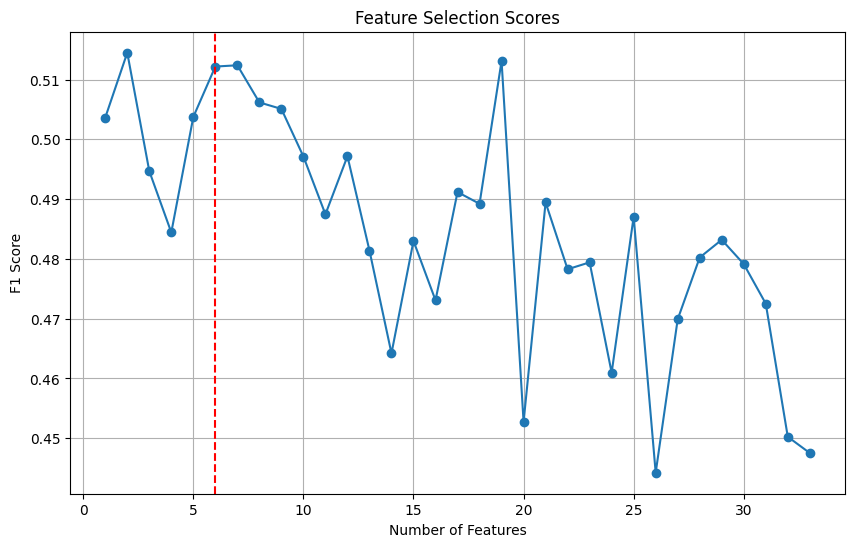

Optimal number of features: 6
Best score: 0.5145


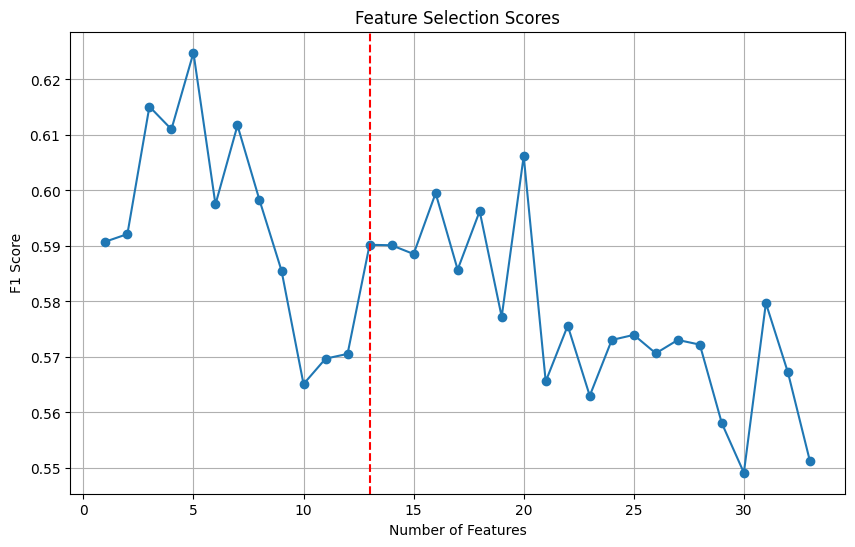

Optimal number of features: 13
Best score: 0.6248

Results for Logistic Regression on EmoSounds after Feature selection and before Weight Balancing dataset:
Train F1: 0.4856 | Train Accuracy: 0.5500
Test F1: 0.4258 | Test Accuracy: 0.5417

Results for Random Forest on EmoSounds after Feature selection and before Weight Balancing dataset:
Train F1: 0.7475 | Train Accuracy: 0.7806
Test F1: 0.5926 | Test Accuracy: 0.6750

Results for XGBoost on EmoSounds after Feature selection and before Weight Balancing dataset:
Train F1: 0.8153 | Train Accuracy: 0.8639
Test F1: 0.5041 | Test Accuracy: 0.6833

Results for Logistic Regression on IADSED after Feature selection and before Weight Balancing dataset:
Train F1: 0.6250 | Train Accuracy: 0.6631
Test F1: 0.5995 | Test Accuracy: 0.6505

Results for Random Forest on IADSED after Feature selection and before Weight Balancing dataset:
Train F1: 0.8530 | Train Accuracy: 0.8667
Test F1: 0.6007 | Test Accuracy: 0.6613

Results for XGBoost on IADSED afte

In [38]:
# RFE Feature selection
X_emosound_train_selected, X_emosound_val_selected, X_emosound_test_selected, best_rfe = find_optimal_features(
    X_emosound_train, X_emosound_val, X_emosound_test, y_emosound_train
)

X_iadsed_train_selected, X_iadsed_val_selected, X_iadsed_test_selected, best_rfe = find_optimal_features(
    X_iadsed_train, X_iadsed_val, X_iadsed_test, y_iadsed_train
)

# Training and Evaluating the model
emosound_results_fs_nowb = train_and_evaluate_models(
    X_emosound_train_selected, X_emosound_val_selected, X_emosound_test_selected,
    y_emosound_train, y_emosound_val, y_emosound_test,
    dataset_name="EmoSounds after Feature selection and before Weight Balancing"
)

iadsed_results_fs_nowb = train_and_evaluate_models(
    X_iadsed_train_selected, X_iadsed_val_selected, X_iadsed_test_selected,
    y_iadsed_train, y_iadsed_val, y_iadsed_test,
    dataset_name="IADSED after Feature selection and before Weight Balancing"
)

### To Balance the classes data weigh (distribution) using SMOTE

In [39]:
def balance_classes(X_train, X_val, y_train, y_val, dataset_name):
    smote = SMOTE(random_state=42)

    # Apply SMOTE only to training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Keep original validation data unchanged
    X_val_balanced, y_val_balanced = X_val, y_val

    print(f"\nClass distribution after SMOTE for {dataset_name}:")
    print("Training set distribution:")
    print(Counter(y_train_balanced))
    print("\nValidation set distribution:")
    print(Counter(y_val_balanced))

    return X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced

### Performance before Feature selection and after Weight Balancing

In [40]:
# Weight Balance
X_emosound_train_balanced, X_emosound_val_balanced, y_emosound_train_balanced, y_emosound_val_balanced = balance_classes(
    X_emosound_train, X_emosound_val, y_emosound_train, y_emosound_val, "EmoSounds"
)

X_iadsed_train_balanced, X_iadsed_val_balanced, y_iadsed_train_balanced, y_iadsed_val_balanced = balance_classes(
    X_iadsed_train, X_iadsed_val, y_iadsed_train, y_iadsed_val, "IADSED"
)

# Training and Evaluating the model
emosound_results_nofs_wb = train_and_evaluate_models(
    X_emosound_train_balanced, X_emosound_val_balanced, X_emosound_test,
    y_emosound_train_balanced, y_emosound_val_balanced, y_emosound_test,
    dataset_name="EmoSounds before Feature selection and after Weight Balancing"
)

iadsed_results_nofs_wb = train_and_evaluate_models(
    X_iadsed_train_balanced, X_iadsed_val_balanced, X_iadsed_test,
    y_iadsed_train_balanced, y_iadsed_val_balanced, y_iadsed_test,
    dataset_name="IADSED before Feature selection and after Weight Balancing"
)


Class distribution after SMOTE for EmoSounds:
Training set distribution:
Counter({2: 148, 1: 148, 3: 148, 0: 148})

Validation set distribution:
Counter({1: 42, 3: 38, 2: 29, 0: 11})

Class distribution after SMOTE for IADSED:
Training set distribution:
Counter({0: 244, 1: 244, 2: 244, 3: 244})

Validation set distribution:
Counter({1: 86, 3: 39, 0: 32, 2: 29})

Results for Logistic Regression on EmoSounds before Feature selection and after Weight Balancing dataset:
Train F1: 0.6234 | Train Accuracy: 0.6334
Test F1: 0.4842 | Test Accuracy: 0.5667

Results for Random Forest on EmoSounds before Feature selection and after Weight Balancing dataset:
Train F1: 0.9526 | Train Accuracy: 0.9527
Test F1: 0.6552 | Test Accuracy: 0.7250

Results for XGBoost on EmoSounds before Feature selection and after Weight Balancing dataset:
Train F1: 0.9966 | Train Accuracy: 0.9966
Test F1: 0.6364 | Test Accuracy: 0.7250

Results for Logistic Regression on IADSED before Feature selection and after Weight B

### Performance after Feature selection and after Weight Balancing

In [41]:
# Weight Balance
X_emosound_train_balanced, X_emosound_val_balanced, y_emosound_train_balanced, y_emosound_val_balanced = balance_classes(
    X_emosound_train_selected, X_emosound_val_selected, y_emosound_train, y_emosound_val, "EmoSounds"
)

X_iadsed_train_balanced, X_iadsed_val_balanced, y_iadsed_train_balanced, y_iadsed_val_balanced = balance_classes(
    X_iadsed_train_selected, X_iadsed_val_selected, y_iadsed_train, y_iadsed_val, "IADSED"
)

# Training and Evaluating the model
emosound_results_fs_wb = train_and_evaluate_models(
    X_emosound_train_balanced, X_emosound_val_balanced, X_emosound_test_selected,
    y_emosound_train_balanced, y_emosound_val_balanced, y_emosound_test,
    dataset_name="EmoSounds after Feature selection and after Weight Balancing"
)

iadsed_results_fs_wb = train_and_evaluate_models(
    X_iadsed_train_balanced, X_iadsed_val_balanced, X_iadsed_test_selected,
    y_iadsed_train_balanced, y_iadsed_val_balanced, y_iadsed_test,
    dataset_name="IADSED after Feature selection and after Weight Balancing"
)


Class distribution after SMOTE for EmoSounds:
Training set distribution:
Counter({2: 148, 1: 148, 3: 148, 0: 148})

Validation set distribution:
Counter({1: 42, 3: 38, 2: 29, 0: 11})

Class distribution after SMOTE for IADSED:
Training set distribution:
Counter({0: 244, 1: 244, 2: 244, 3: 244})

Validation set distribution:
Counter({1: 86, 3: 39, 0: 32, 2: 29})

Results for Logistic Regression on EmoSounds after Feature selection and after Weight Balancing dataset:
Train F1: 0.5624 | Train Accuracy: 0.5743
Test F1: 0.4609 | Test Accuracy: 0.5750

Results for Random Forest on EmoSounds after Feature selection and after Weight Balancing dataset:
Train F1: 0.8554 | Train Accuracy: 0.8581
Test F1: 0.5926 | Test Accuracy: 0.6667

Results for XGBoost on EmoSounds after Feature selection and after Weight Balancing dataset:
Train F1: 0.9133 | Train Accuracy: 0.9139
Test F1: 0.6085 | Test Accuracy: 0.6833

Results for Logistic Regression on IADSED after Feature selection and after Weight Balan

# plot best models confusion matrix

In [76]:
def get_best_models_summary(dfs_dict, set_name='Test', metric='F1 Score'):
    summary_data = []

    for dataset_name, results_df in dfs_dict.items():
        required_columns = {'Model', 'Set', 'F1 Score', 'Accuracy', 'Predictions'}
        if not required_columns.issubset(results_df.columns):
            raise ValueError(f"{dataset_name} results_df must contain {required_columns} columns.")

        # Get the best model based on the specified metric for the test set
        best_model_row = results_df.loc[results_df['Set'] == set_name].sort_values(by=metric, ascending=False).iloc[0]
        best_model_name = best_model_row['Model']

        # Retrieve the train accuracy for the same model
        train_row = results_df[(results_df['Model'] == best_model_name) & (results_df['Set'] == 'Train')]
        train_accuracy = train_row['Accuracy'].values[0] if not train_row.empty else None

        summary_data.append({
            'Dataset': dataset_name,
            'Best Model': best_model_name,
            'Train Accuracy': train_accuracy,
            f'{set_name} Accuracy': best_model_row['Accuracy'],
            f'{set_name} {metric}': best_model_row[metric]
        })

    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df


In [77]:
# Define the datasets and their respective results DataFrames
dfs_dict = {
    'emosound_nofs_nowb': emosound_results_nofs_nowb,
    'iadsed_nofs_nowb': iadsed_results_nofs_nowb,
    'emosound_fs_nowb': emosound_results_fs_nowb,
    'iadsed_fs_nowb': iadsed_results_fs_nowb,
    'emosound_nofs_wb': emosound_results_nofs_wb,
    'iadsed_nofs_wb': iadsed_results_nofs_wb,
    'emosound_fs_wb': emosound_results_fs_wb,
    'iadsed_fs_wb': iadsed_results_fs_wb
}

# Get the summary table
summary_df = get_best_models_summary(dfs_dict)
summary_df

,Dataset,Best Model,Train Accuracy,Test Accuracy,Test F1 Score
0,emosound_nofs_nowb,Random Forest,0.933333,0.691667,0.565093
1,iadsed_nofs_nowb,Logistic Regression,0.702703,0.650538,0.605994
2,emosound_fs_nowb,Random Forest,0.780556,0.675000,0.592605
3,iadsed_fs_nowb,Random Forest,0.866667,0.661290,0.600736
4,emosound_nofs_wb,Random Forest,0.952703,0.725000,0.655249
5,iadsed_nofs_wb,Random Forest,0.909836,0.661290,0.601018
6,emosound_fs_wb,XGBoost,0.913851,0.683333,0.608503
7,iadsed_fs_wb,Random Forest,0.887295,0.661290,0.607824


## No Feature Selection, No Data Balancing


Best Model: Random Forest
Test F1 Score: 0.5651
Test Accuracy: 0.6917

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        17
           1       0.72      0.79      0.75        42
           2       0.36      0.38      0.37        13
           3       0.79      0.85      0.82        48

    accuracy                           0.69       120
   macro avg       0.59      0.56      0.57       120
weighted avg       0.68      0.69      0.68       120



<Figure size 640x480 with 0 Axes>

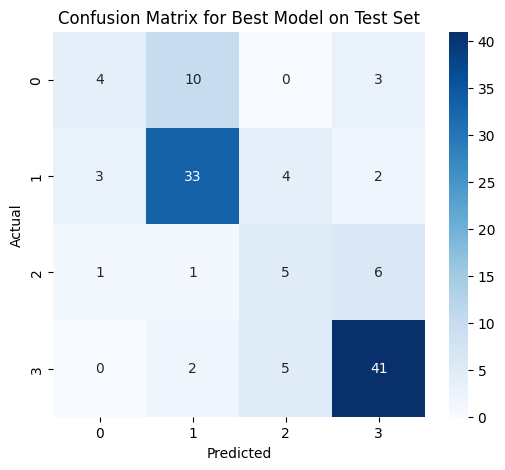

In [52]:
plot_best_model_confusion_matrix(results_df=emosound_results_nofs_nowb, y_test=y_emosound_test, set_name='Test', metric='F1 Score')


Best Model: Logistic Regression
Test F1 Score: 0.6060
Test Accuracy: 0.6505

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.51      0.55        41
           1       0.85      0.77      0.81        81
           2       0.37      0.64      0.47        25
           3       0.65      0.56      0.60        39

    accuracy                           0.65       186
   macro avg       0.61      0.62      0.61       186
weighted avg       0.68      0.65      0.66       186



<Figure size 640x480 with 0 Axes>

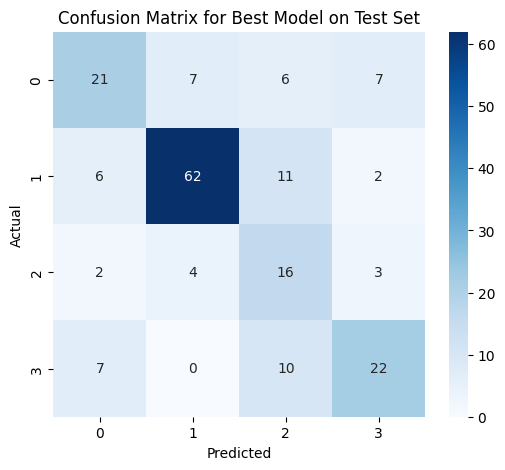

In [53]:
plot_best_model_confusion_matrix(results_df=iadsed_results_nofs_nowb, y_test=y_iadsed_test, set_name='Test', metric='F1 Score')

## Feature Selection, No Data Balancing


Best Model: Random Forest
Test F1 Score: 0.5926
Test Accuracy: 0.6750

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.41      0.41        17
           1       0.75      0.64      0.69        42
           2       0.35      0.54      0.42        13
           3       0.85      0.83      0.84        48

    accuracy                           0.68       120
   macro avg       0.59      0.61      0.59       120
weighted avg       0.70      0.68      0.68       120



<Figure size 640x480 with 0 Axes>

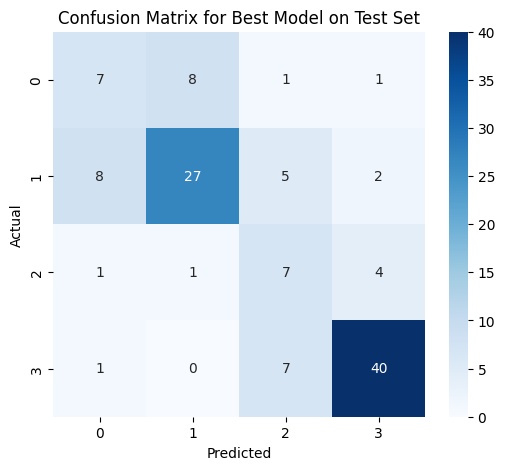

In [54]:
plot_best_model_confusion_matrix(results_df=emosound_results_fs_nowb, y_test=y_emosound_test, set_name='Test', metric='F1 Score')


Best Model: Random Forest
Test F1 Score: 0.6007
Test Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57        41
           1       0.86      0.81      0.84        81
           2       0.36      0.48      0.41        25
           3       0.57      0.59      0.58        39

    accuracy                           0.66       186
   macro avg       0.60      0.61      0.60       186
weighted avg       0.68      0.66      0.67       186



<Figure size 640x480 with 0 Axes>

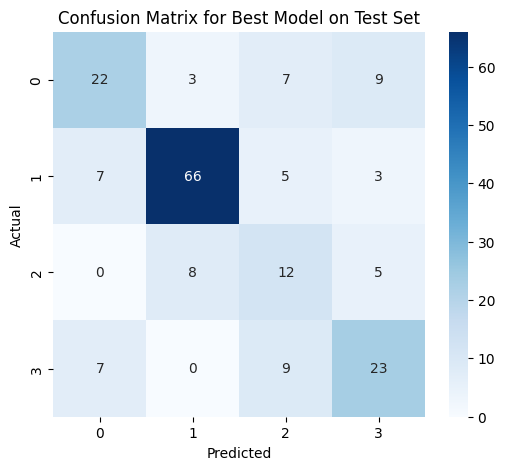

In [55]:
plot_best_model_confusion_matrix(results_df=iadsed_results_fs_nowb, y_test=y_iadsed_test, set_name='Test', metric='F1 Score')

## No Feature Selection, Data Balancing


Best Model: Random Forest
Test F1 Score: 0.6552
Test Accuracy: 0.7250

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.85      0.69      0.76        42
           2       0.35      0.54      0.42        13
           3       0.84      0.85      0.85        48

    accuracy                           0.72       120
   macro avg       0.66      0.67      0.66       120
weighted avg       0.75      0.72      0.73       120



<Figure size 640x480 with 0 Axes>

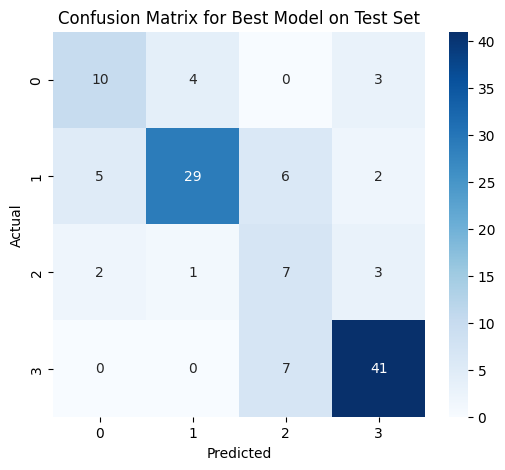

In [56]:
plot_best_model_confusion_matrix(results_df=emosound_results_nofs_wb, y_test=y_emosound_test, set_name='Test', metric='F1 Score')


Best Model: Random Forest
Test F1 Score: 0.6010
Test Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        41
           1       0.87      0.80      0.83        81
           2       0.32      0.44      0.37        25
           3       0.57      0.62      0.59        39

    accuracy                           0.66       186
   macro avg       0.60      0.60      0.60       186
weighted avg       0.69      0.66      0.67       186



<Figure size 640x480 with 0 Axes>

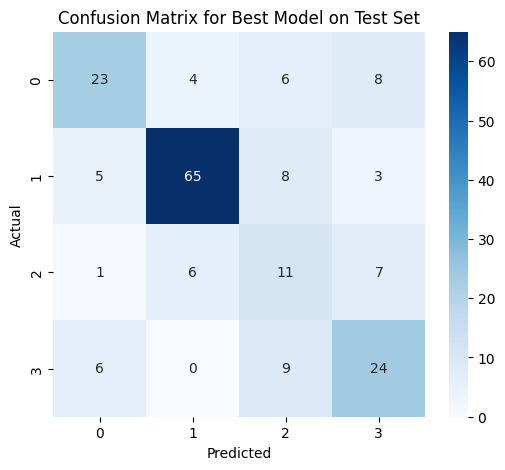

In [57]:
plot_best_model_confusion_matrix(results_df=iadsed_results_nofs_wb, y_test=y_iadsed_test, set_name='Test', metric='F1 Score')

## Feature Selection, Data Balancing


Best Model: XGBoost
Test F1 Score: 0.6085
Test Accuracy: 0.6833

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        17
           1       0.82      0.67      0.74        42
           2       0.30      0.46      0.36        13
           3       0.80      0.81      0.80        48

    accuracy                           0.68       120
   macro avg       0.61      0.62      0.61       120
weighted avg       0.71      0.68      0.69       120



<Figure size 640x480 with 0 Axes>

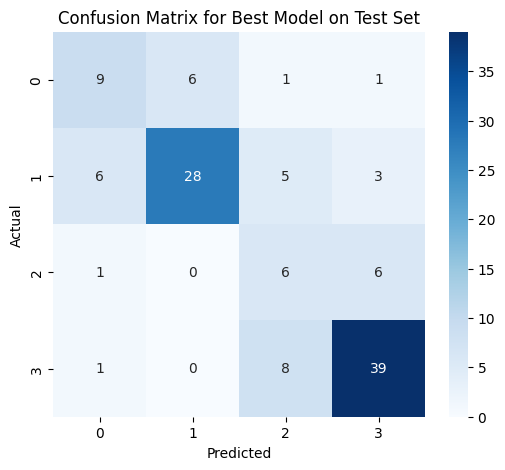

In [58]:
plot_best_model_confusion_matrix(results_df=emosound_results_fs_wb, y_test=y_emosound_test, set_name='Test', metric='F1 Score')


Best Model: Random Forest
Test F1 Score: 0.6078
Test Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59        41
           1       0.86      0.79      0.83        81
           2       0.36      0.52      0.43        25
           3       0.57      0.62      0.59        39

    accuracy                           0.66       186
   macro avg       0.61      0.62      0.61       186
weighted avg       0.69      0.66      0.67       186



<Figure size 640x480 with 0 Axes>

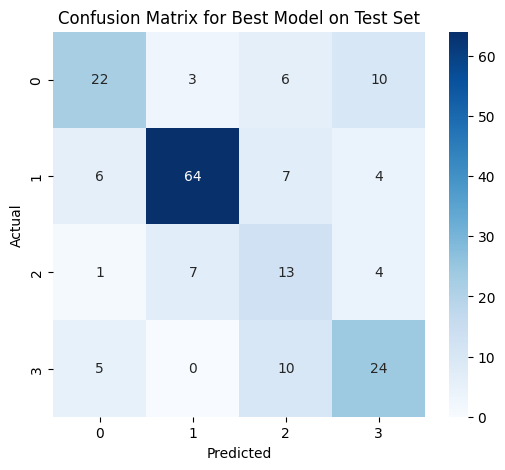

In [59]:
plot_best_model_confusion_matrix(results_df=iadsed_results_fs_wb, y_test=y_iadsed_test, set_name='Test', metric='F1 Score')

## emosounds all results

In [60]:
emosound_results_nofs_nowb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,EmoSounds before Feature selection and before ...,Logistic Regression,Train,0.567084,0.619444,"[3, 0, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 2, ..."
1,EmoSounds before Feature selection and before ...,Logistic Regression,Validation,0.494787,0.558333,"[3, 1, 2, 3, 1, 0, 2, 0, 3, 3, 3, 3, 1, 2, 1, ..."
2,EmoSounds before Feature selection and before ...,Logistic Regression,Test,0.494488,0.583333,"[1, 0, 1, 1, 3, 2, 1, 2, 1, 3, 3, 3, 1, 3, 0, ..."
3,EmoSounds before Feature selection and before ...,Random Forest,Train,0.926301,0.933333,"[2, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 2, 3, 2, 2, ..."
4,EmoSounds before Feature selection and before ...,Random Forest,Validation,0.591256,0.691667,"[3, 1, 1, 3, 1, 1, 2, 0, 3, 3, 3, 2, 1, 1, 1, ..."
5,EmoSounds before Feature selection and before ...,Random Forest,Test,0.565093,0.691667,"[1, 1, 3, 1, 3, 1, 2, 2, 3, 3, 0, 3, 1, 3, 1, ..."
6,EmoSounds before Feature selection and before ...,XGBoost,Train,0.990746,0.994444,"[2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 2, 2, ..."
7,EmoSounds before Feature selection and before ...,XGBoost,Validation,0.541847,0.666667,"[3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, ..."
8,EmoSounds before Feature selection and before ...,XGBoost,Test,0.510098,0.700000,"[1, 1, 3, 1, 3, 1, 2, 2, 3, 3, 0, 3, 1, 3, 1, ..."


In [61]:
emosound_results_fs_nowb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,EmoSounds after Feature selection and before W...,Logistic Regression,Train,0.485571,0.550000,"[3, 0, 3, 3, 1, 3, 3, 3, 0, 2, 1, 3, 3, 2, 1, ..."
1,EmoSounds after Feature selection and before W...,Logistic Regression,Validation,0.488257,0.533333,"[3, 1, 2, 3, 1, 0, 3, 1, 3, 3, 3, 2, 1, 0, 0, ..."
2,EmoSounds after Feature selection and before W...,Logistic Regression,Test,0.425804,0.541667,"[1, 2, 3, 1, 3, 2, 2, 0, 3, 3, 2, 3, 1, 3, 1, ..."
3,EmoSounds after Feature selection and before W...,Random Forest,Train,0.747491,0.780556,"[3, 1, 3, 3, 1, 3, 2, 0, 1, 1, 1, 2, 2, 2, 2, ..."
4,EmoSounds after Feature selection and before W...,Random Forest,Validation,0.586659,0.633333,"[3, 1, 0, 3, 1, 0, 2, 1, 3, 3, 3, 2, 1, 0, 1, ..."
5,EmoSounds after Feature selection and before W...,Random Forest,Test,0.592605,0.675000,"[1, 1, 3, 1, 3, 2, 2, 2, 3, 3, 1, 3, 1, 3, 1, ..."
6,EmoSounds after Feature selection and before W...,XGBoost,Train,0.815342,0.863889,"[3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 2, 2, ..."
7,EmoSounds after Feature selection and before W...,XGBoost,Validation,0.486184,0.633333,"[3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 3, 2, 1, 1, 1, ..."
8,EmoSounds after Feature selection and before W...,XGBoost,Test,0.504116,0.683333,"[1, 1, 3, 1, 3, 1, 1, 2, 3, 3, 1, 3, 1, 3, 1, ..."


In [62]:
emosound_results_nofs_wb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,EmoSounds before Feature selection and after W...,Logistic Regression,Train,0.623427,0.633446,"[3, 0, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 2, ..."
1,EmoSounds before Feature selection and after W...,Logistic Regression,Validation,0.506607,0.575000,"[3, 1, 2, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 2, 1, ..."
2,EmoSounds before Feature selection and after W...,Logistic Regression,Test,0.484156,0.566667,"[1, 0, 1, 1, 3, 2, 1, 2, 1, 3, 3, 3, 1, 3, 0, ..."
3,EmoSounds before Feature selection and after W...,Random Forest,Train,0.952555,0.952703,"[2, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 2, 3, 2, 2, ..."
4,EmoSounds before Feature selection and after W...,Random Forest,Validation,0.622638,0.666667,"[3, 1, 1, 3, 1, 1, 2, 0, 3, 3, 3, 2, 1, 1, 1, ..."
5,EmoSounds before Feature selection and after W...,Random Forest,Test,0.655249,0.725000,"[0, 1, 3, 0, 3, 2, 2, 2, 3, 3, 0, 3, 1, 3, 0, ..."
6,EmoSounds before Feature selection and after W...,XGBoost,Train,0.996622,0.996622,"[2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 2, 2, ..."
7,EmoSounds before Feature selection and after W...,XGBoost,Validation,0.568824,0.633333,"[2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 3, 2, 1, 1, 1, ..."
8,EmoSounds before Feature selection and after W...,XGBoost,Test,0.636402,0.725000,"[1, 1, 3, 0, 3, 2, 2, 2, 3, 3, 0, 3, 1, 3, 0, ..."


In [63]:
emosound_results_fs_wb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,EmoSounds after Feature selection and after We...,Logistic Regression,Train,0.562413,0.574324,"[3, 0, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 2, 1, ..."
1,EmoSounds after Feature selection and after We...,Logistic Regression,Validation,0.512338,0.558333,"[3, 1, 2, 3, 1, 0, 3, 1, 3, 3, 3, 2, 1, 0, 0, ..."
2,EmoSounds after Feature selection and after We...,Logistic Regression,Test,0.460881,0.575000,"[1, 2, 3, 1, 3, 2, 2, 0, 3, 3, 2, 3, 1, 3, 1, ..."
3,EmoSounds after Feature selection and after We...,Random Forest,Train,0.855439,0.858108,"[2, 0, 3, 3, 1, 3, 2, 3, 1, 2, 1, 2, 2, 2, 2, ..."
4,EmoSounds after Feature selection and after We...,Random Forest,Validation,0.558391,0.591667,"[3, 1, 0, 3, 1, 0, 2, 0, 3, 3, 3, 2, 1, 0, 1, ..."
5,EmoSounds after Feature selection and after We...,Random Forest,Test,0.592552,0.666667,"[0, 1, 3, 1, 3, 2, 2, 2, 3, 3, 2, 3, 1, 3, 1, ..."
6,EmoSounds after Feature selection and after We...,XGBoost,Train,0.913294,0.913851,"[2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3, 2, 2, ..."
7,EmoSounds after Feature selection and after We...,XGBoost,Validation,0.614461,0.650000,"[3, 1, 0, 3, 1, 0, 2, 1, 3, 3, 3, 2, 1, 0, 1, ..."
8,EmoSounds after Feature selection and after We...,XGBoost,Test,0.608503,0.683333,"[0, 1, 3, 0, 3, 2, 2, 2, 3, 3, 3, 3, 1, 3, 1, ..."


## iadsed all results

In [64]:
iadsed_results_nofs_nowb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,IADSED before Feature selection and before Wei...,Logistic Regression,Train,0.670038,0.702703,"[0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 3, 1, 3, 2, 2, ..."
1,IADSED before Feature selection and before Wei...,Logistic Regression,Validation,0.657991,0.698925,"[1, 3, 2, 1, 3, 2, 1, 2, 2, 2, 3, 3, 1, 3, 1, ..."
2,IADSED before Feature selection and before Wei...,Logistic Regression,Test,0.605994,0.650538,"[1, 1, 1, 2, 1, 3, 0, 2, 3, 3, 0, 1, 1, 1, 2, ..."
3,IADSED before Feature selection and before Wei...,Random Forest,Train,0.887933,0.897297,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
4,IADSED before Feature selection and before Wei...,Random Forest,Validation,0.695871,0.736559,"[1, 3, 2, 2, 3, 2, 1, 2, 2, 2, 0, 3, 1, 2, 1, ..."
5,IADSED before Feature selection and before Wei...,Random Forest,Test,0.598363,0.661290,"[1, 1, 1, 1, 0, 0, 3, 2, 3, 3, 0, 1, 1, 2, 2, ..."
6,IADSED before Feature selection and before Wei...,XGBoost,Train,0.986777,0.987387,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
7,IADSED before Feature selection and before Wei...,XGBoost,Validation,0.630991,0.709677,"[1, 3, 2, 3, 3, 3, 0, 2, 3, 3, 0, 3, 1, 3, 1, ..."
8,IADSED before Feature selection and before Wei...,XGBoost,Test,0.545851,0.650538,"[1, 1, 1, 1, 0, 0, 3, 2, 3, 3, 1, 1, 1, 1, 3, ..."


In [65]:
iadsed_results_fs_nowb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,IADSED after Feature selection and before Weig...,Logistic Regression,Train,0.624981,0.663063,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 2, 2, ..."
1,IADSED after Feature selection and before Weig...,Logistic Regression,Validation,0.600810,0.650538,"[1, 3, 2, 0, 3, 2, 0, 2, 2, 2, 3, 3, 1, 0, 1, ..."
2,IADSED after Feature selection and before Weig...,Logistic Regression,Test,0.599524,0.650538,"[1, 1, 1, 1, 0, 3, 2, 2, 3, 3, 0, 1, 1, 1, 2, ..."
3,IADSED after Feature selection and before Weig...,Random Forest,Train,0.852985,0.866667,"[0, 1, 2, 2, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
4,IADSED after Feature selection and before Weig...,Random Forest,Validation,0.697401,0.736559,"[1, 3, 2, 2, 3, 2, 3, 2, 2, 2, 0, 3, 1, 3, 1, ..."
5,IADSED after Feature selection and before Weig...,Random Forest,Test,0.600736,0.661290,"[1, 1, 1, 1, 0, 0, 3, 2, 0, 3, 0, 1, 1, 2, 2, ..."
6,IADSED after Feature selection and before Weig...,XGBoost,Train,0.884529,0.902703,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 2, 2, ..."
7,IADSED after Feature selection and before Weig...,XGBoost,Validation,0.639236,0.715054,"[1, 3, 2, 3, 3, 3, 3, 1, 2, 3, 0, 3, 1, 3, 1, ..."
8,IADSED after Feature selection and before Weig...,XGBoost,Test,0.550492,0.634409,"[1, 1, 1, 1, 3, 0, 3, 2, 3, 3, 0, 1, 1, 1, 2, ..."


In [66]:
iadsed_results_nofs_wb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,IADSED before Feature selection and after Weig...,Logistic Regression,Train,0.754449,0.754098,"[0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 3, 2, 2, ..."
1,IADSED before Feature selection and after Weig...,Logistic Regression,Validation,0.640708,0.688172,"[1, 3, 2, 1, 3, 2, 1, 2, 2, 2, 3, 3, 1, 3, 1, ..."
2,IADSED before Feature selection and after Weig...,Logistic Regression,Test,0.600010,0.650538,"[1, 1, 1, 2, 0, 3, 3, 2, 3, 3, 0, 1, 1, 1, 2, ..."
3,IADSED before Feature selection and after Weig...,Random Forest,Train,0.910228,0.909836,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 2, 2, ..."
4,IADSED before Feature selection and after Weig...,Random Forest,Validation,0.644449,0.682796,"[1, 3, 2, 2, 3, 2, 1, 2, 2, 2, 0, 3, 1, 2, 1, ..."
5,IADSED before Feature selection and after Weig...,Random Forest,Test,0.601018,0.661290,"[1, 1, 1, 1, 0, 0, 3, 2, 3, 3, 0, 1, 1, 1, 2, ..."
6,IADSED before Feature selection and after Weig...,XGBoost,Train,0.993848,0.993852,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
7,IADSED before Feature selection and after Weig...,XGBoost,Validation,0.657368,0.715054,"[1, 3, 2, 3, 3, 2, 0, 2, 3, 1, 0, 3, 1, 3, 1, ..."
8,IADSED before Feature selection and after Weig...,XGBoost,Test,0.591532,0.666667,"[1, 1, 1, 2, 0, 0, 3, 2, 3, 3, 1, 1, 1, 1, 3, ..."


In [67]:
iadsed_results_fs_wb

,Dataset,Model,Set,F1 Score,Accuracy,Predictions
0,IADSED after Feature selection and after Weigh...,Logistic Regression,Train,0.684906,0.685451,"[0, 1, 2, 3, 1, 1, 3, 1, 1, 0, 3, 1, 3, 2, 2, ..."
1,IADSED after Feature selection and after Weigh...,Logistic Regression,Validation,0.616251,0.661290,"[1, 3, 2, 0, 3, 2, 0, 2, 2, 2, 0, 3, 1, 3, 1, ..."
2,IADSED after Feature selection and after Weigh...,Logistic Regression,Test,0.595304,0.645161,"[1, 1, 1, 1, 0, 3, 2, 2, 3, 3, 0, 1, 1, 1, 2, ..."
3,IADSED after Feature selection and after Weigh...,Random Forest,Train,0.887592,0.887295,"[0, 1, 2, 2, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
4,IADSED after Feature selection and after Weigh...,Random Forest,Validation,0.677657,0.720430,"[1, 3, 2, 0, 3, 3, 3, 2, 2, 2, 0, 3, 1, 3, 1, ..."
5,IADSED after Feature selection and after Weigh...,Random Forest,Test,0.607824,0.661290,"[1, 1, 1, 1, 0, 0, 3, 2, 0, 3, 0, 1, 1, 1, 2, ..."
6,IADSED after Feature selection and after Weigh...,XGBoost,Train,0.972249,0.972336,"[0, 1, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 2, 2, ..."
7,IADSED after Feature selection and after Weigh...,XGBoost,Validation,0.672259,0.720430,"[1, 3, 2, 0, 3, 3, 0, 2, 2, 2, 0, 3, 1, 3, 1, ..."
8,IADSED after Feature selection and after Weigh...,XGBoost,Test,0.590345,0.645161,"[1, 1, 1, 0, 0, 0, 3, 2, 3, 3, 0, 1, 1, 2, 2, ..."
